# Отчёт о выполнении лабораторной работы

Дописала недостоющие методы градиентного спуска - функция *gradient_descent* в модуле *optimization* и процедуры линейного поиска - метод *line_search* в классе *LineSearchTool* в модуле *optimization*.

Сделала оракул логистической регрессии (класс LogRegL2Oracle в модуле oracles). Еще сделала реализацию вспомогательной функции create_log_reg_oracle в модуле oracles

Написала подсчет разностных производных (функции grad_finite_diff и hess_finite_diff в модуле oracles).

Реализовала метод Ньютона (функция newton в модуле optimization)

## 3.1 Эксперимент: Траектория градиентного спуска на квадратичной функции

Проанализируйте траекторию градиентного спуска для нескольких квадратичных функций: при думайте две-три квадратичныедвумерныефункции, на которых работа метода будет отличаться, нарисуйте графики с линиями уровня функций и траекториями методов.  

Попробуйте ответить на следующий вопрос:Как отличается поведение метода в зависимости от числа обусловленности функции, выбора начальной точки и стратегии выбора шага (константная стратегия, Армихо, Вульф)?

Для рисования линий уровня можете воспользоваться функцией `plot_levels`, а для рисования траекторий `plot_trajectory` из файла `plot_trajectory_2d.py`, прилагающегося к заданию. Также обратите внимание, что оракул квадратичной функции `QuadraticOracle` уже реализован в модуле `oracles`. Он реализует функцию $f(x) = (1/2)〈Ax, x〉−〈b, x〉$, где $A∈S^n_{++}, b ∈ R^n$.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import oracles
import optimization
import presubmit_tests as pt
from plot_trajectory_2d import plot_levels, plot_trajectory
from sklearn.datasets import load_svmlight_file

Мы реализуем вычисление разностных производных с помощью функций `grad_finite_diff` и `hess_finite_diff` в модуле oracles. Для проверки корректности расчета градиента и гессиана в логистическом оракуле воспользуемся этими функциями. Сгенерируем небольшую модельную выборку (матрицу A и вектор b) и сравним результаты методов `grad` и `hess` с соответствующими разностными аппроксимациями в нескольких тестовых точках x.

In [2]:
A = np.array([[1, 2], [3, -4]])
b = np.array([10, 11])
regcoef = 2
oracle = oracles.create_log_reg_oracle(A, b, regcoef)
f = lambda x: oracle.func(x)
x = np.array([1, 2])

for x in np.array([[1, 2], [-1, -2], [3, 0]]):
    print('x =', x)
    print('Градиент через grad:', oracle.grad(x))
    print('Градиент через grad_finite_diff:', oracles.grad_finite_diff(f, x))
    print('Гессиан через hess:')
    print(oracle.hess(x))
    print('Гессиан через hess_finite_diff')
    print(oracles.hess_finite_diff(f, x))
    print()

x = [1 2]
Градиент через grad: [-14.5  26. ]
Градиент через grad_finite_diff: [-14.50000013  25.99999931]
Гессиан через hess:
[[ 2.00000000e+00 -7.79748855e-24]
 [-7.79748855e-24  2.00000000e+00]]
Гессиан через hess_finite_diff
[[ 2.00003569e+00 -7.10542736e-05]
 [-7.10542736e-05  1.99989358e+00]]

x = [-1 -2]
Градиент через grad: [ -7. -14.]
Градиент через grad_finite_diff: [ -6.99999987 -14.00000009]
Гессиан через hess:
[[2.00000000e+00 1.92874985e-22]
 [1.92874985e-22 2.00000000e+00]]
Гессиан через hess_finite_diff
[[1.99996464 0.        ]
 [0.         2.00000017]]

x = [3 0]
Градиент через grad: [ 6.00000000e+00 -9.34807787e-13]
Градиент через grad_finite_diff: [5.99999996 0.        ]
Гессиан через hess:
[[2.00000000e+00 9.34807787e-14]
 [9.34807787e-14 2.00000000e+00]]
Гессиан через hess_finite_diff
[[2.00001793e+00 1.77635684e-05]
 [1.77635684e-05 2.00000017e+00]]



In [3]:
pt.test_python3()
pt.test_QuadraticOracle()
pt.test_log_reg_usual()
pt.test_log_reg_oracle_calls()
pt.test_grad_finite_diff_1()
pt.test_grad_finite_diff_2()
pt.test_hess_finite_diff_1()
pt.test_hess_finite_diff_2()
pt.test_line_search()
pt.test_gd_basic()
pt.test_newton_basic()
pt.test_newton_1d()
pt.test_newton_fail()

Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]
Iteration 0: x_k = [1. 1.]


Проанализируем поведение градиентного спуска на нескольких квадратичных функциях: зададим две-три двумерные квадратичные функции, для которых работа метода будет различаться, и построим графики с уровнями функций и траекториями движения методов.

In [4]:
def draw(oracle, methods, x_start, descent, tolerance=1e-5, max_iter=10000, trace=False, display=False):
    for i in range(len(methods)):
        fig, ax = plt.subplots(1, len(x_start), figsize=(17, 5))
        s = ''
        for key, val in methods[i].items():
            s = s + str(key) + ': ' + str(val) + ', '
        fig.suptitle(s, fontsize=15)
        plt.subplots_adjust(top=0.85)
        
        for j in range(len(x_start)):
            [x_star, msg, history] = descent(oracle, x_start[j], tolerance=tolerance, max_iter=max_iter, line_search_options = methods[i], trace=trace, display=display)
            plot_levels(oracle.func, ax[j])
            plot_trajectory(oracle.func, ax[j], history['x'])
            ax[j].set_title("x_start: " + str(x_start[j]) + ', iterations: ' + str(len(history['time'])))
            ax[j].legend()

In [5]:
x_start = np.array([[-4., -4.], [2., -4.], [5., 4.]])
methods = [{'method': 'Constant', 'c': 0.1}, 
           {'method': 'Armijo', 'alpha_0': 100.0, 'c1':0.1}, {'method':'Armijo', 'alpha_0':1.0, 'c1':0.4}, 
           {"method":'Wolfe', 'c1':1e-4, 'c2':0.8, 'alpha_0':1.0}, {"method":'Wolfe', 'c1':0.4, 'c2':0.95, 'alpha_0':100.0}]

Первая квадратичная функция

Число обусловленности: 2.0000000000000004


c:\Users\1\Desktop\3курс_1сем\ML_autumn_2024\hw22\hw2\optimization.py:89: DeprecationWarning: Please use `scalar_search_wolfe2` from the `scipy.optimize` namespace, the `scipy.optimize.linesearch` namespace is deprecated.
  alpha = scipy.optimize.linesearch.scalar_search_wolfe2(phi, derphi, c1=self.c1, c2=self.c2)[0]


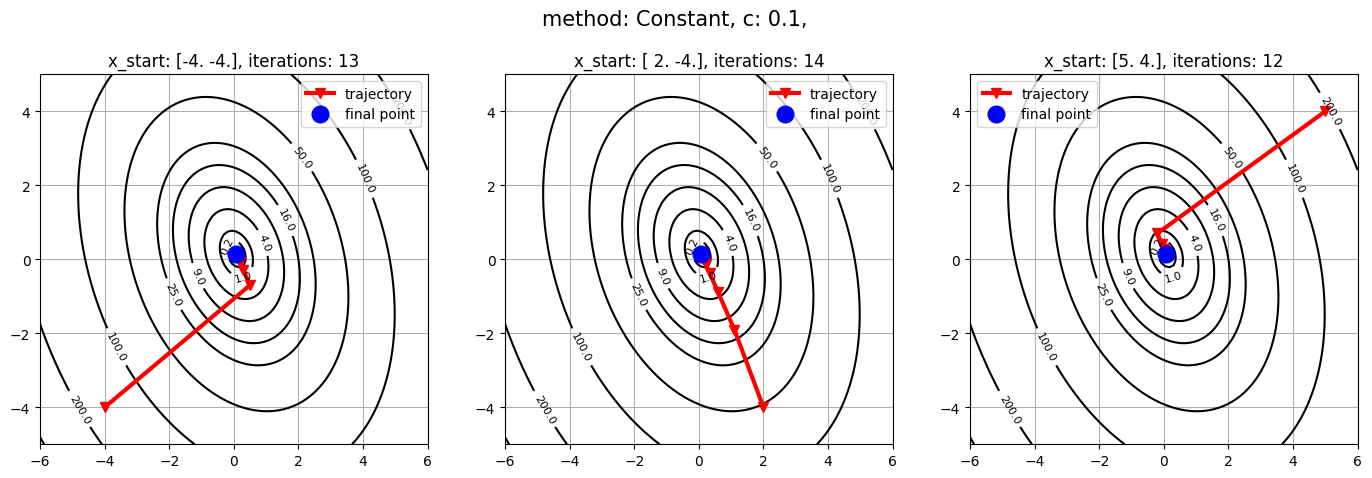

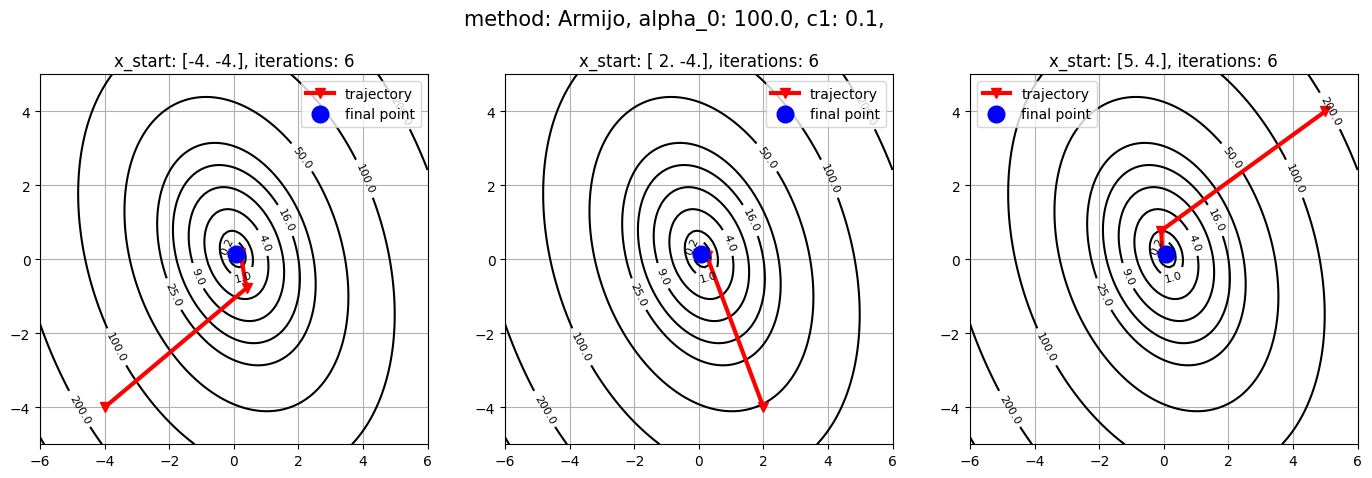

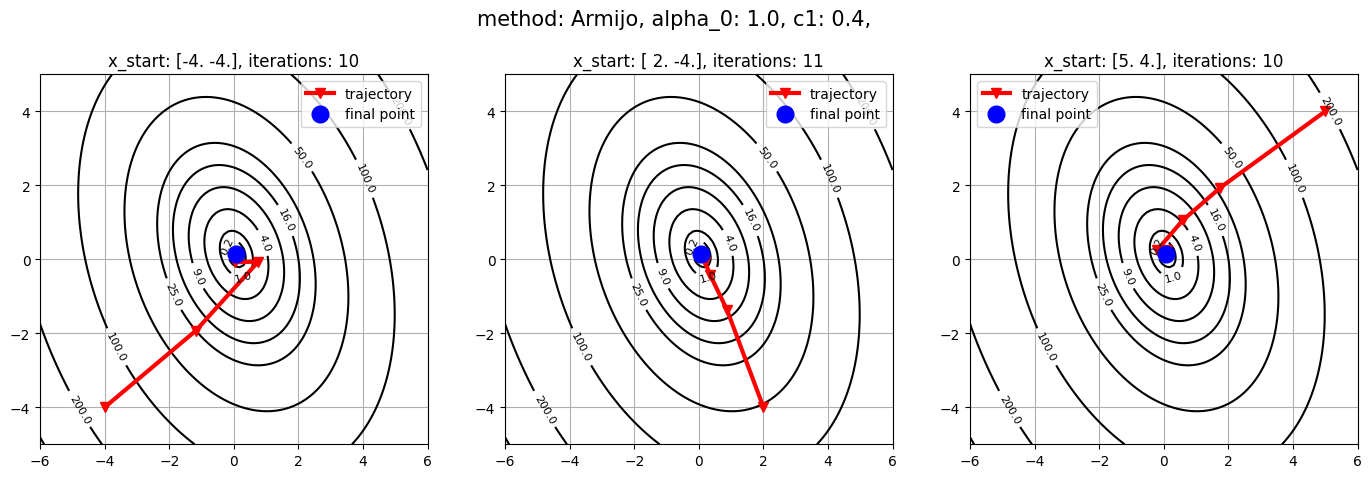

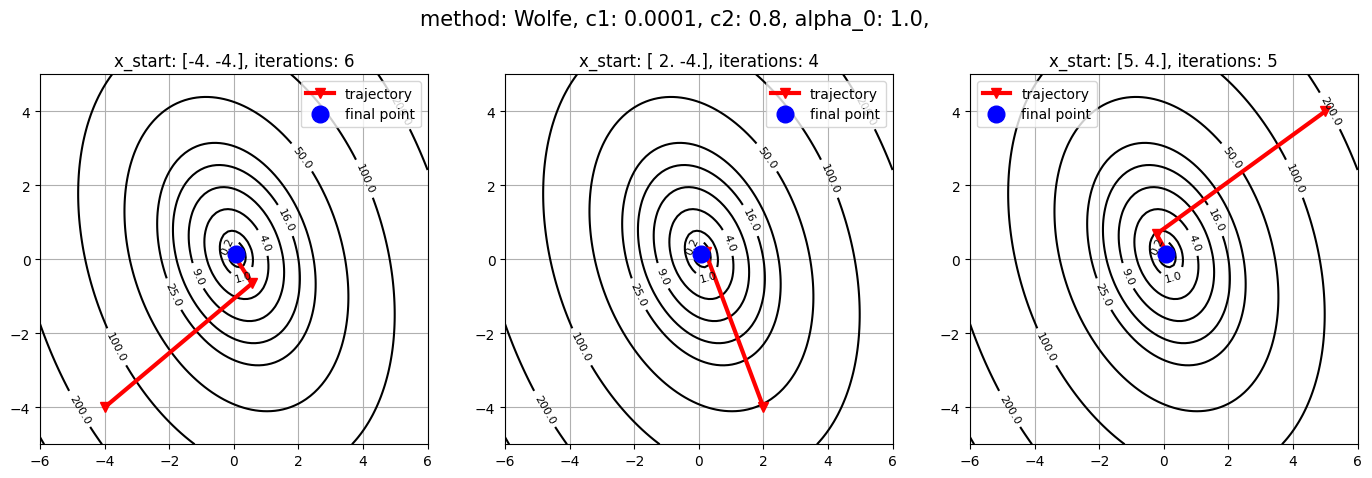

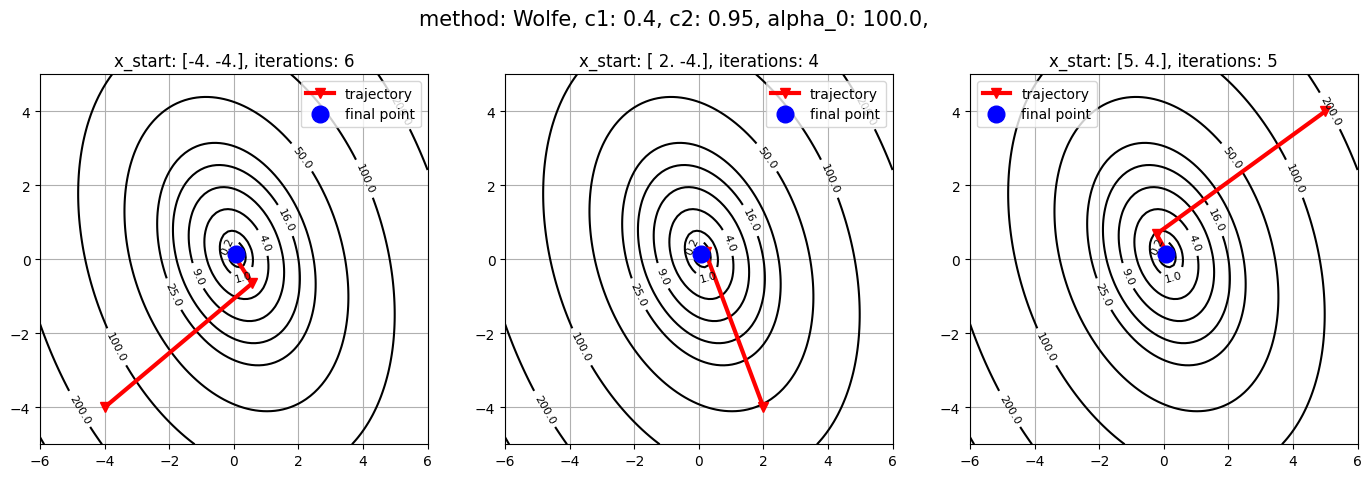

In [6]:
A = np.array([[9., 2.], [2., 6.]])
b = np.array([1., 1.])
oracle = oracles.QuadraticOracle(A, b)
print('Число обусловленности:', np.linalg.cond(A))

descent = optimization.gradient_descent
draw(oracle, methods, x_start, descent, tolerance=1e-5, max_iter=1000, trace=True, display=False)

Вторая квадратичная функция

Число обусловленности: 13.288382660794833


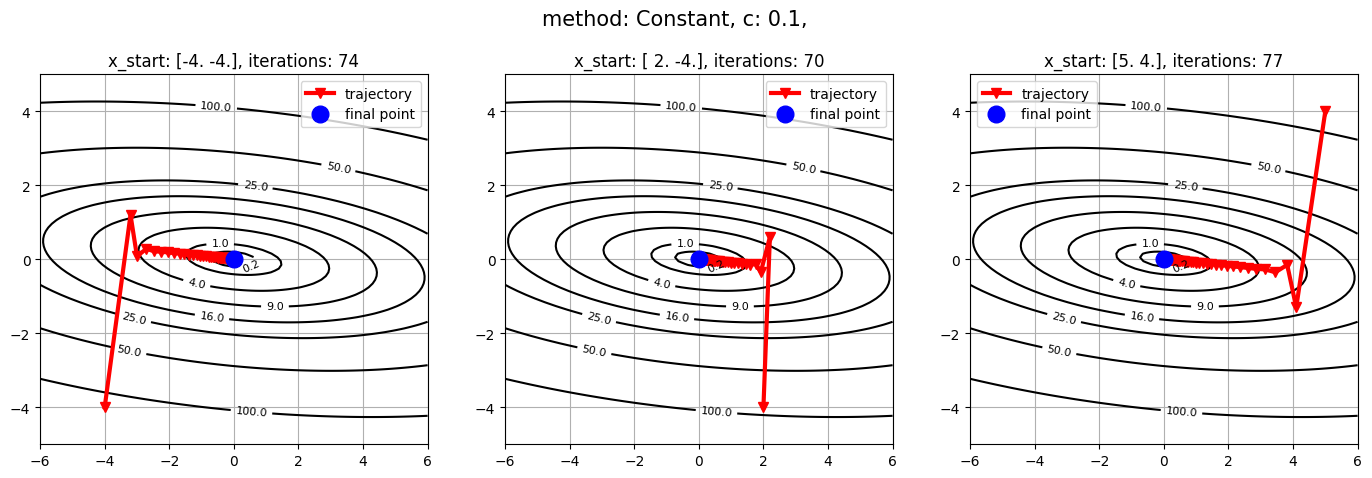

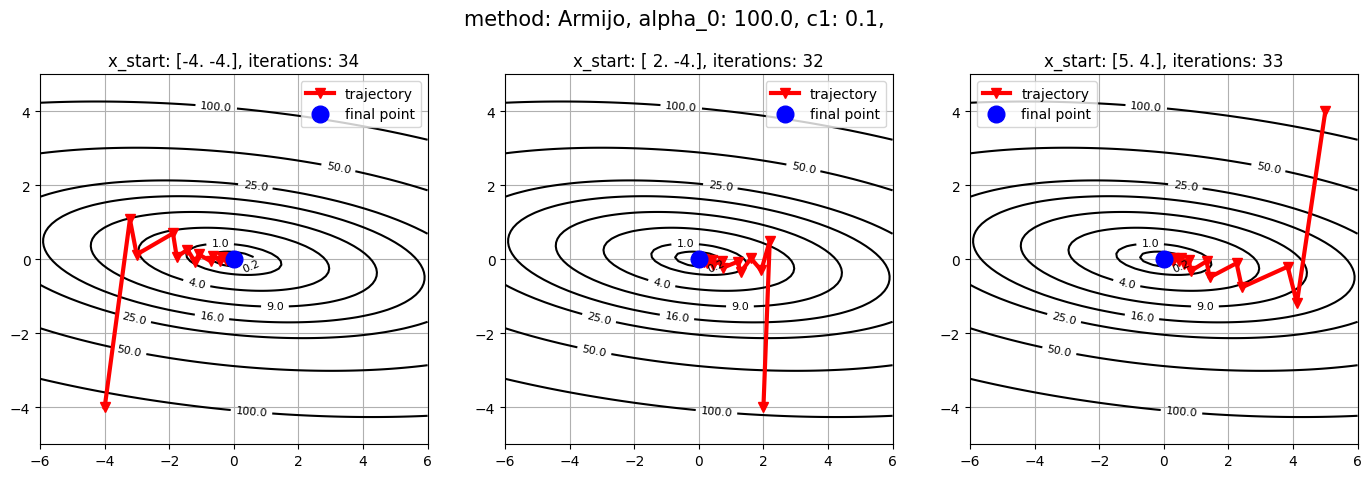

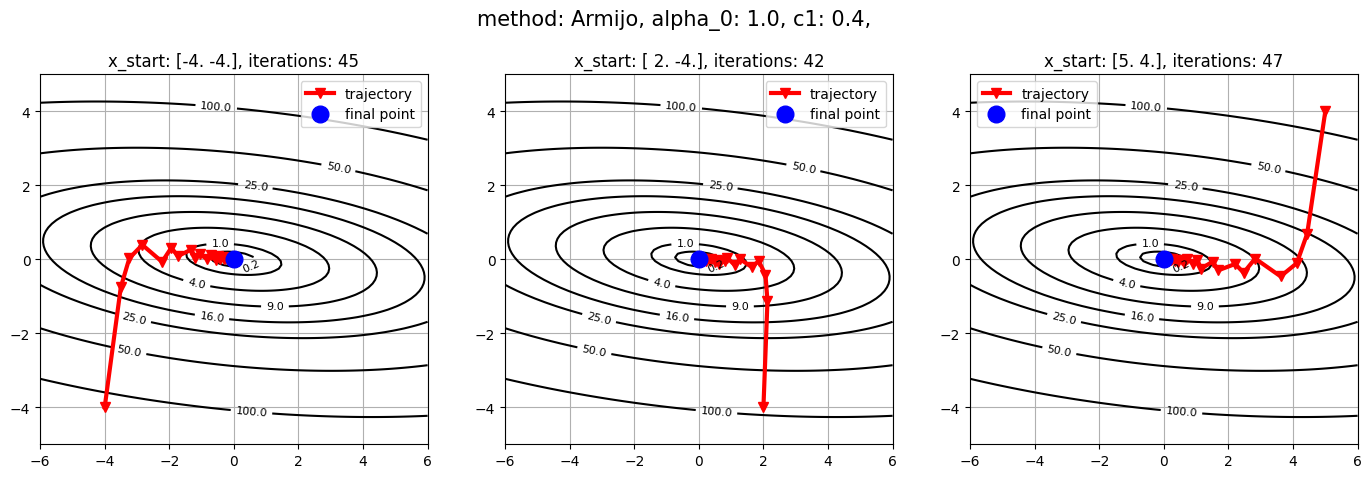

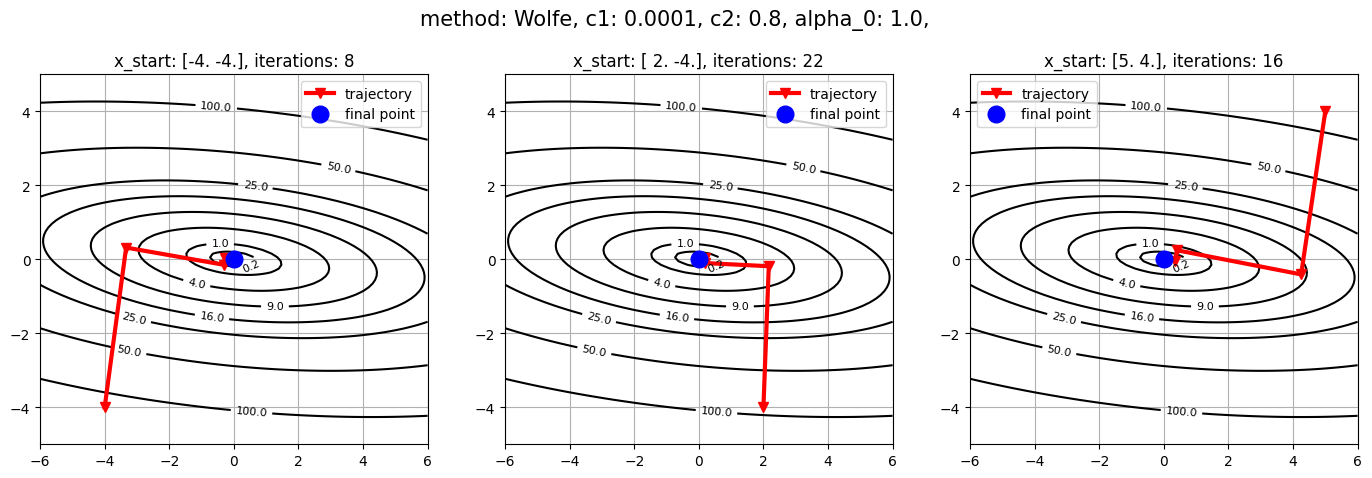

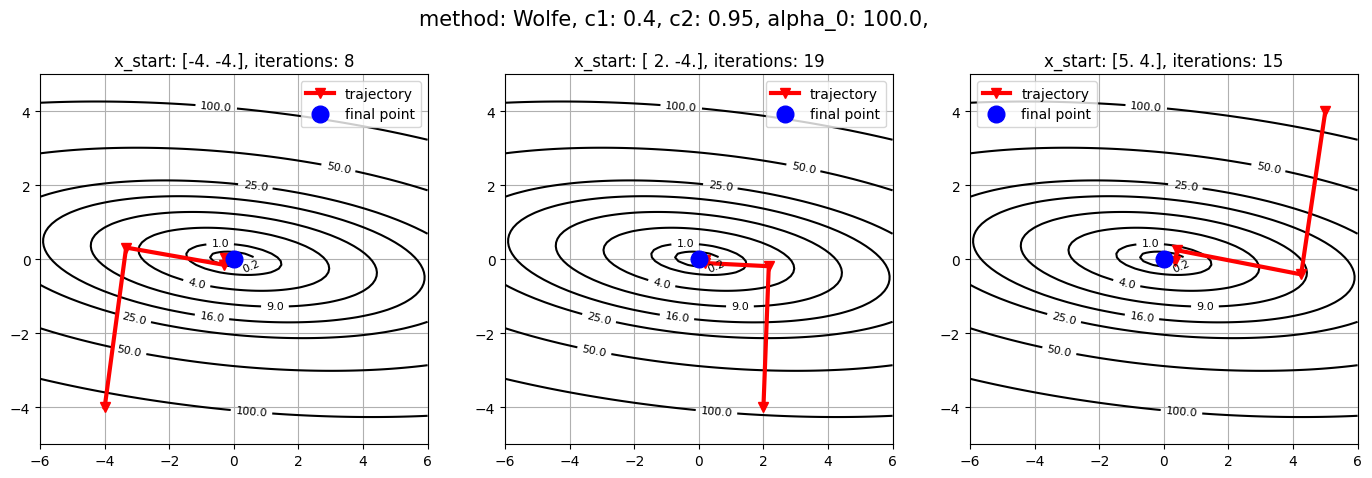

In [7]:
A = np.array([[1.0, 1.0], [1.0, 12.]])
b = np.array([0.0, 0.0])
oracle = oracles.QuadraticOracle(A, b)
print('Число обусловленности:', np.linalg.cond(A))

descent = optimization.gradient_descent
draw(oracle, methods, x_start, descent, tolerance=1e-5, max_iter=1000, trace=True, display=False)

При увеличении числа условий необходимо проводить больше итераций для достижения наилучшего результата. \
Чем дальше находится начальная точка от оптимального значения, тем больше итераций потребуется для её достижения. \
Меньше всего итераций потребуется при использовании стратегии выбора шага с использованием метода Вульфа, и больше всего – при использовании константного метода.

## Эксперимент 2: Зависимость числа итераций градиентного спуска от числа обусловленности и размерности пространства

Исследуем, как зависит число итераций, необходимое градиентному спуску для сходимости, от следующих двух параметров:
1) числа обусловленности κ ≥ 1 оптимизируемой функции
2) размерности пространства n оптимизируемых переменных.

Для заданных параметров n и κ мы создадим случайную квадратичную задачу размера n с определенным числом обусловленности κ. Затем мы запустим на этой задаче градиентный спуск с определенной степенью точности и измерим количество итераций T(n,κ), необходимых для успешного завершения задачи.

Зафиксируем некоторое значение размерности n. Переберем различные числа обусловленности κ по сетке и построим график зависимости T(κ,n) против κ. Поскольку каждый раз квадратичная задача генерируется случайным образом, то повторим этот эксперимент несколько раз. В результате для фиксированного значения n у нас получится целое семейство кривых зависимости T(κ,n) от κ. Нарисуем все эти кривые одним и тем же цветом для наглядности.

Теперь мы увеличим значение n и проведем эксперимент еще раз. Это даст нам новый набор данных T(n',κ) для различных значений κ. Мы отобразим эти данные в виде кривых на графике, используя тот же цвет, что и ранее (например, синий), чтобы их можно было легко сравнить.

Затем мы повторим этот процесс для других значений n. Это даст нам различные семейства кривых, каждая из которых будет окрашена в свой цвет (например, красный, синий, зеленый и так далее), соответствующий своему значению n.

Мы также заметим, что значения размерности n следует выбирать на основе логарифмической шкалы (например, n = 10, n = 100, n = 1000 и так далее).

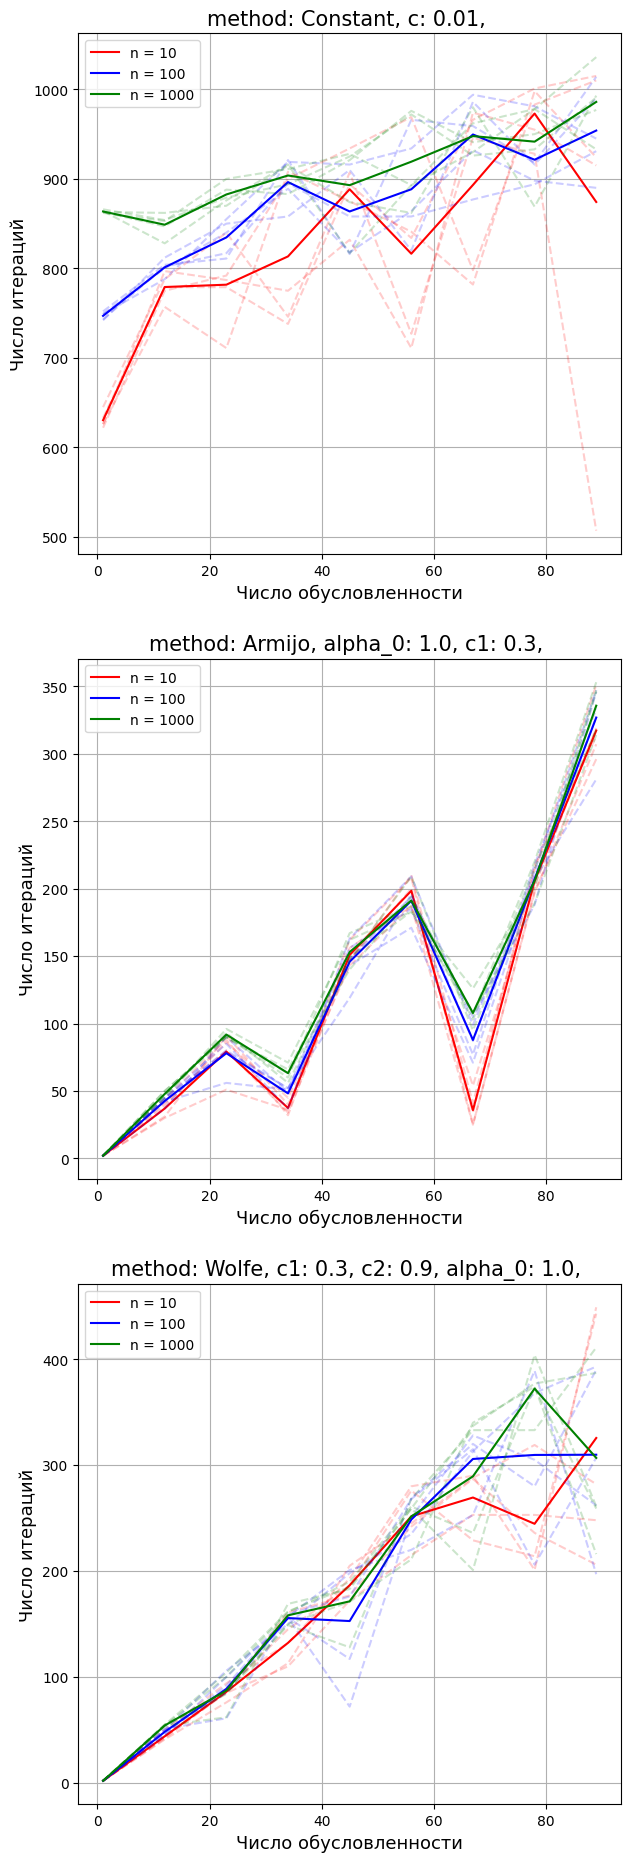

In [8]:
options = [(10, 'r'), (100, 'b'), (1000, 'g')]
K = np.arange(1, 100, 11)
methods = [{'method': 'Constant', 'c': 0.01}, 
           {'method': 'Armijo', 'alpha_0': 1.0, 'c1': 0.3}, 
           {"method": 'Wolfe', 'c1': 0.3, 'c2': 0.9, 'alpha_0': 1.0}]

fig, ax = plt.subplots(3, 1, figsize=(7, 23))

for i in range(len(methods)):
    for n, colour in options:
        I = np.zeros(len(K))
        number_of_experiments = 5
        for j in range(number_of_experiments):
            it = []
            for k in K:
                a = np.random.uniform(1, k, n)
                a[0] = 1.
                a[-1] = k
                A = scipy.sparse.diags(a)
                b = np.random.rand(n) * k
                oracle = oracles.QuadraticOracle(A, b)
                x_star, msg, history = optimization.gradient_descent(oracle, np.ones(n), 
                                                              line_search_options=methods[i], trace=True)
                if msg != "success":
                    print(msg)
                it.append(len(history['time']))
            I += np.array(it)
            ax[i].plot(K, it, color=colour, linestyle='dashed', alpha=0.2)
        ax[i].plot(K, I / number_of_experiments, color=colour, label=('n = '+str(n)))
        ax[i].legend()
        ax[i].set_xlabel("Число обусловленности", fontsize=13)
        ax[i].set_ylabel("Число итераций", fontsize=13)
        s = ''
        for key, val in methods[i].items():
            s = s + str(key) + ': ' + str(val) + ', '
        ax[i].set_title(s, fontsize=15)
        ax[i].grid()

В среднем, с увеличением числа обусловленности растет число итераций. Причем растет одинаково для всех размерностей, разве что для константного метода можно заметить, что преимущественно итераций больше там, где размерность больше.

## Эксперимент 3: Сравнение методов градиентного спуска и Ньютона на реальной задаче логистической регрессии

Мы проведем сравнение методов градиентного спуска и Ньютона при обучении логистической регрессии на трех наборах данных с сайта LIBSVM3: w8a, gisette и real-sim. В качестве коэффициента регуляризации мы применим стандартное значение: λ = 1/m

Для обоих методов будем использовать параметры по умолчанию. Начнем с начальной точки $x_0$ = 0.

Построим графики сходимости следующих двух видов:
- Зависимость значения функции от реального времени работы метода.
- Зависимость относительного квадрата нормы градиента $∥∇f(x_k)∥^2_2/∥∇f(x_0)∥^2_2$ (в логарифмической шкале) против реального времени работы.


In [9]:
def graph_compare(svm_file):
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    A, b = load_svmlight_file(svm_file)
    regcoef = 1 / len(b)
    oracle = oracles.create_log_reg_oracle(A, b, regcoef)
    
    _, _, history_gd = optimization.gradient_descent(oracle, np.zeros(A.shape[1]), trace=True)
    ax[0].plot(history_gd['time'], history_gd['func'], label='Градиентный спуск')

    _, _, history_n = optimization.newton(oracle, np.zeros(A.shape[1]), trace=True)
    ax[0].plot(history_n['time'], history_n['func'], label='Метод Ньютона')
    
    ax[0].set_xlabel('Реальное время работы метода')
    ax[0].set_ylabel('Значение функции')
    ax[0].legend()

    ax[1].plot(history_gd['time'], np.array(history_gd['grad_norm']) ** 2 / history_gd['grad_norm'][0] ** 2, label="Градиентный спуск")
    ax[1].plot(history_n['time'], np.array(history_n['grad_norm']) ** 2 / history_n['grad_norm'][0] ** 2, label="Метод Ньютона")
    
    ax[1].set_yscale('log')
    ax[1].set_xlabel('Реальное время работы метода')
    ax[1].set_ylabel('Относительный квадрат нормы градиента')
    ax[1].legend()

Сравнение методов для данных из w8a:

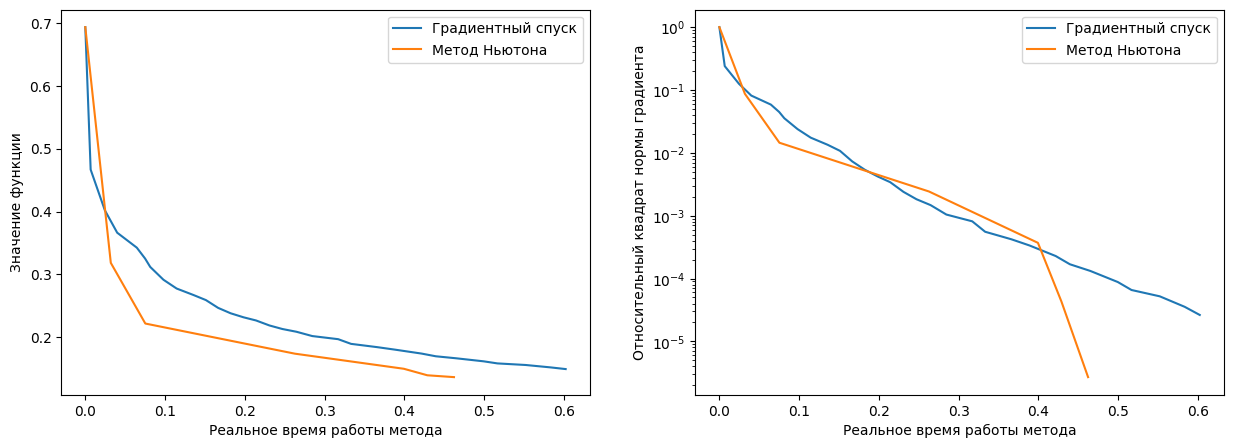

In [10]:
graph_compare('data/w8a.txt')

С этого момента загрузка занимала долгое время и я так и не дождалась(

Сравнение методов для данных из gisette_scale:

KeyboardInterrupt: 

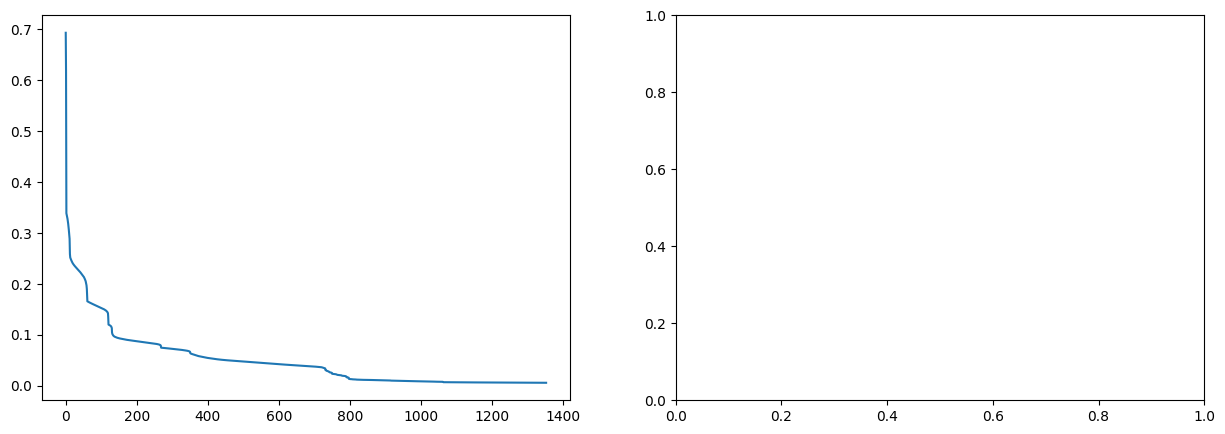

In [11]:
graph_compare('data/gisette_scale.bz2')

Сравнение методов для данных из real-sim:

In [ ]:
graph_compare('data/real-sim.bz2')

c:\Users\nader\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\optimize\_linesearch.py:466: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


В данных w8a градиентный спуск быстрее работает в начале (для небольшой точности), но медленнее в конце (для большой точности). В других случаях градиентный спуск сработал быстрее.